In [55]:
import yfinance as yf
import pandas as pd
import numpy as np
import random
import math
import statistics
from collections import namedtuple, deque, Counter
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [56]:
device = torch.device("cuda")

# Define the Actor and Critic

Actor - proposes an action given a state $u(s|theta^u)\rightarrow a$

Critic - predicts the actions quality given the state and action $Q(s,a)$

NoiseClass - generates the noise, we will be using an Ornstein-Uhlenbeck Process 

Will start by doing the pendulum problem

In [57]:
class OUNoise:
    # https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process
    def __init__(self, mean, stdev, theta=0.15, dt = 1e-2, x_init=None):
        self.theta = theta
        self.mean = mean
        self.stdev = stdev
        self.dt = dt 
        self.x_init = x_init
        
    def __call__(self):
        x = self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt + \
            self.stdev * np.sqrt(self.dt) * np.random.normal(size = self.mean.shape)
        
        self.x_prev = x
        return x
    
    def reset(self):
        if self.x_init is not None:
            self.x_prev = self.x_init
        else:
            self.x_prev = np.zeros_like(self.mean)
            

In [58]:
class MemoryReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.data = deque(maxlen=capacity)
        
    def __len__(self):
        return len(self.data)

    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.data.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.stack(states), np.stack(actions), np.stack(rewards), np.stack(next_states), np.stack(dones)

    

In [59]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, action_dim)
        self.max_action = max_action

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.max_action * torch.tanh(self.fc3(x))
        return x


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 1)

    def forward(self, x, u):
        x = torch.relu(self.fc1(torch.cat([x, u], 1)))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [47]:
def fanin_init (size, fanin=None):
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).uniform_(-v, v)

class Actor(nn.Module):

    def __init__(self, n_observations, n_actions, hidden1=256, hidden2=256, init_w=3e-3, max_action_val=1):
        super(Actor, self).__init__()
        self.fc1= nn.Linear(n_observations, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        
        self.fc3 = nn.Linear(hidden2, n_actions)
        self.init_weights(init_w)
        self.max_action_val = max_action_val
        
    def init_weights(self, init_w):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-init_w, init_w)
        

    def forward(self, state):
        state = F.relu(self.fc1(state))
        out = F.relu(self.fc2(state))
        out = torch.tanh(self.fc3(out)) * self.max_action_val
        return out
    
class Critic(nn.Module):

    def __init__(self, n_observations, n_actions, hidden1=256, hidden2=256, init_w=3e-3):
        super(Critic, self).__init__()
        self.fc1= nn.Linear(n_observations, hidden1)
        self.fc2 = nn.Linear(hidden1+n_actions, hidden2)
        
        self.fc3 = nn.Linear(hidden2, n_actions)
        self.init_weights(init_w)
        
    def init_weights(self, init_w):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-init_w, init_w)
        

    def forward(self, state, action):
        state = F.relu(self.fc1(state))
        out = F.relu(self.fc2(torch.cat([state, action], 1)))
        out = F.tanh(self.fc3(out))
        return out
        

In [69]:
class DDPG:
    def __init__(self, state_dim, action_dim, max_action_val, gamma=0.99, noise_var=0.2, tau=0.001) -> None:
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.actor = Actor(state_dim, action_dim, max_action_val).to(device=device)
        self.target_actor = Actor(state_dim, action_dim, max_action_val).to(device=device)
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3, amsgrad=True)

        self.critic = Critic(state_dim, action_dim).to(device=device)
        self.target_critic = Critic(state_dim, action_dim).to(device=device)
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=2e-3, amsgrad=True)
        
        self.gamma = gamma
        self.tau = tau
        self.max_action_val = max_action_val
        self.memory = MemoryReplay(100000)
        self.ou_noise = OUNoise(np.zeros(1), np.ones(1)*noise_var)
        self.state_dim = state_dim
        self.action_dim = action_dim
        
    def select_action(self, state, add_noise=True, noise_factor=1):
        state = torch.tensor(state, dtype=torch.float32, device=self.device)
        samp_action = self.actor(state).cpu().data.numpy().flatten()
        samp_action += np.random.normal(0, self.max_action_val*.1, size=self.action_dim) * noise_factor
        # if add_noise:
        #     noise = self.ou_noise()
        #     samp_action = samp_action + noise*noise_factor
        return samp_action.clip(-self.max_action_val, self.max_action_val)
    
    def step(self, batch_size=64):
        if len(self.memory) < batch_size:
            return
        
        state, action, reward, next_state, done = self.memory.sample(batch_size)
        
        state = torch.tensor(state, dtype=torch.float32, device=self.device)
        action = torch.tensor(action, dtype=torch.float32, device=self.device)
        reward = torch.tensor(reward, dtype=torch.float32, device=self.device)
        next_state = torch.tensor(next_state, dtype=torch.float32, device=self.device)
        done = torch.tensor(done, dtype=torch.float32, device=self.device)
        
        next_action = self.target_actor(next_state)
        target_Q = self.target_critic(next_state, next_action)
        target_Q = reward+((1-done)*self.gamma*target_Q).detach()
        
        # Update the critic
        current_Q = self.critic(state, action)
        critic_loss = nn.MSELoss()(current_Q, target_Q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Update the actor
        actor_loss = -1*self.critic(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Soft update the weights
        tc_sd = self.target_critic.state_dict()
        c_sd = self.critic.state_dict()
        for kkey in tc_sd:
            tc_sd[kkey] = c_sd[kkey]*self.tau+tc_sd[kkey]*(1-self.tau)
        self.target_critic.load_state_dict(tc_sd)
            
        ta_sd = self.target_actor.state_dict()
        a_sd = self.actor.state_dict()
        for kkey in ta_sd:
            ta_sd[kkey] = a_sd[kkey]*self.tau+ta_sd[kkey]*(1-self.tau)
        self.target_actor.load_state_dict(ta_sd)
        
        
        
        
        

In [70]:
import gymnasium as gym

env = gym.make("Pendulum-v1")

NUM_STATES = env.observation_space.shape[0]
print("Size of State Space: {}".format(NUM_STATES))
NUM_ACTIONS = env.action_space.shape[0]
print("Size of Action Space: {}".format(NUM_ACTIONS))

UPPER_BOUND = env.action_space.high[0]
LOWER_BOUND = env.action_space.low[0]

print("Max Value of Action: {}".format(UPPER_BOUND))
print("Min Value of Action: {}".format(LOWER_BOUND))

Size of State Space: 3
Size of Action Space: 1
Max Value of Action: 2.0
Min Value of Action: -2.0


In [71]:
training_env = DDPG(NUM_STATES, NUM_ACTIONS, UPPER_BOUND)

n_eps = 100
n_steps = 1000

acc_rewards = []

for episode in range(n_eps):
    state = env.reset()[0]
    
    acc_reward = 0
    training_env.ou_noise.reset()
    
    for step in range(n_steps):
        action = training_env.select_action(state, noise_factor=episode/n_eps)
        
        next_state, reward, done, _, _ = env.step(action)
        
        training_env.memory.push(state, action, reward, next_state, done)
        training_env.step()
        
        state = next_state
        acc_reward+=reward
        
        if done:
            print("Done Reached")
            break
        
    print(f"{episode}/{n_eps} -- reward = {acc_reward}")
    acc_rewards.append(acc_reward)
    

/home/danny/anaconda3/envs/py10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0/100 -- reward = -7578.054154876232
1/100 -- reward = -7486.455048697697
2/100 -- reward = -7478.136386534093
3/100 -- reward = -7535.0969291745105
4/100 -- reward = -7534.4057148719585
5/100 -- reward = -7520.07577625386
6/100 -- reward = -7430.369337912506
7/100 -- reward = -7192.315343248922
8/100 -- reward = -5126.616138417103
9/100 -- reward = -4062.4014515121494
10/100 -- reward = -7511.953415076618
11/100 -- reward = -3820.2222999514534
12/100 -- reward = -1927.9117200898472
13/100 -- reward = -1786.3978071054364
14/100 -- reward = -1015.9188162891934
15/100 -- reward = -130.75518657390998
16/100 -- reward = -265.08569925808115
17/100 -- reward = -319.9286210152586
18/100 -- reward = -118.96319003665624
19/100 -- reward = -265.9377799381149
20/100 -- reward = -268.03784336732014
21/100 -- reward = -137.61007472544264
22/100 -- reward = -270.29941683218505
23/100 -- reward = -144.7813776389747
24/100 -- reward = -34.63947922291931
25/100 -- reward = -258.74925253890723
26/100 --

In [8]:
actor = Actor(NUM_STATES).to(device=device)
target_actor = Actor(NUM_STATES).to(device=device)
target_actor.load_state_dict(actor.state_dict())
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)

critic = Critic(NUM_STATES, NUM_ACTIONS).to(device=device)
target_critic = Critic(NUM_STATES, NUM_ACTIONS).to(device=device)
target_critic.load_state_dict(critic.state_dict())
critic_optimizer = optim.Adam(critic.parameters(), lr=2e-3)

In [9]:
# Define the hyper parameters 
stdev_ou = 0.2
ou = OUNoise(np.zeros(1), float(stdev_ou)*np.ones(1))

LR_critic = 0.002
LR_actor = 0.001

optimizer_critic = optim.AdamW(critic.parameters(), lr=LR_critic, amsgrad=True)
optimizer_critic = optim.AdamW(actor.parameters(), lr=LR_actor, amsgrad=True)

N_episodes = 100

gamma = 0.99

tau = 0.005

memreplay = MemoryReplay(buffer_cap=50000)

BATCH_SIZE = 64
max_iters = 5000

In [10]:
def select_action(state, noise_object):
    samp_action = actor(state).squeeze(0)
    noise = noise_object()
    samp_action = samp_action + noise
    return torch.clip(samp_action, min=LOWER_BOUND, max=UPPER_BOUND).unsqueeze(0)
    

In [11]:

for ee in range(N_episodes):
    state = env.reset()
    ou.reset()
    ep_reward = 0
    
    for ii in range(max_iters):
        
        
        state_t = torch.tensor(state[0], dtype=torch.float32, device=device).unsqueeze(0)
        action = select_action(state_t, ou)
        next_state, reward, done, info, _ = env.step(action.cpu().data.numpy().flatten())
        
        memreplay.record((state[0], action.cpu().data.numpy(), reward, next_state))
        
        if ii < BATCH_SIZE:
            continue # Use the batch size as a warmup
        
        next_state_t = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        
        
        ep_reward += reward
        
        sampled_states, sampled_actions, sampled_rewards, sampled_next_states = memreplay.sample(BATCH_SIZE)
        
        sampled_states_pt = torch.tensor(sampled_states, device=device, dtype=torch.float32)
        sampled_actions_pt = torch.tensor(sampled_actions, device=device, dtype=torch.float32)
        sampled_rewards_pt = torch.tensor(sampled_rewards, device=device, dtype=torch.float32)
        sampled_next_states_pt = torch.tensor(sampled_next_states, device=device, dtype=torch.float32)
        
        # print(sampled_states_pt.shape)
        # print(sampled_actions_pt.shape)
        # print(sampled_rewards_pt.shape)
        # print(sampled_next_states_pt.shape)
        # target_actions = 
        
        target_Q = target_critic((sampled_next_states_pt, target_actor(sampled_next_states_pt)))
        target_Q = sampled_rewards_pt + (done*gamma*target_Q).detach()
        
        current_Q = critic((sampled_states_pt, sampled_actions_pt))
        
        critic_loss = F.mse_loss(current_Q, target_Q)
        
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()
        
        actor_loss = -1*critic((sampled_states_pt, actor(sampled_states_pt))).mean()
        
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        
        tc_sd = target_critic.state_dict()
        c_sd = critic.state_dict()
        for kkey in tc_sd:
            tc_sd[kkey] = c_sd[kkey]*tau+tc_sd[kkey]*(1-tau)
        target_critic.load_state_dict(tc_sd)
            
        ta_sd = target_actor.state_dict()
        a_sd = actor.state_dict()
        for kkey in ta_sd:
            ta_sd[kkey] = a_sd[kkey]*tau+ta_sd[kkey]*(1-tau)
        target_actor.load_state_dict(ta_sd)
        
        if done:
            break
    print(f"{ee}/{N_episodes} -- tot_reward = {ep_reward}")
    

0/100 -- tot_reward = -37188.7333840813
1/100 -- tot_reward = -33877.45892774843
2/100 -- tot_reward = -39250.50503821361
3/100 -- tot_reward = -31569.02205782897
4/100 -- tot_reward = -38405.218558377484
5/100 -- tot_reward = -41881.27640285178
6/100 -- tot_reward = -35111.75722879709
7/100 -- tot_reward = -35077.072909475864
8/100 -- tot_reward = -32843.92614158432
9/100 -- tot_reward = -35151.440918415385
10/100 -- tot_reward = -38282.878934543354
11/100 -- tot_reward = -30952.669117370053
12/100 -- tot_reward = -35694.2872901006
13/100 -- tot_reward = -35640.72623146077
14/100 -- tot_reward = -30088.16226142767
15/100 -- tot_reward = -31225.219174509544
16/100 -- tot_reward = -31852.453765221326
17/100 -- tot_reward = -34033.25803694379
18/100 -- tot_reward = -34214.909731290514
19/100 -- tot_reward = -41369.732386027594
20/100 -- tot_reward = -31581.88198660186
21/100 -- tot_reward = -32495.57165691677
22/100 -- tot_reward = -32859.82070197991
23/100 -- tot_reward = -34668.3730333

# Load in the data

In [2]:
top_8_tech = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'TSLA', 'TSM']
top_4_tech = ['AAPL', 'MSFT', 'GOOG', 'AMZN']

used_tech = top_4_tech

In [3]:
# run this to load the data wo re-downloading
datas = {}
num_shares = {}

for ticker in used_tech:
    datas[ticker] = pd.read_csv(f"data/stocksv1/{ticker}.csv").set_index('Date')
    data = yf.Ticker(ticker)
    
    # Note: This will break if there are any stock splits between the last time the data was downloaded
    # and the time the num shares is computed. Redownload data if this happens
    num_shares[ticker] = int(data.info['marketCap']/data.info['previousClose'])

([<matplotlib.axis.XTick at 0x7fcc351c0d30>,
 [Text(0, 0, '2018-05-10 00:00:00-04:00'),
  Text(1258, 0, '2023-05-09 00:00:00-04:00')])

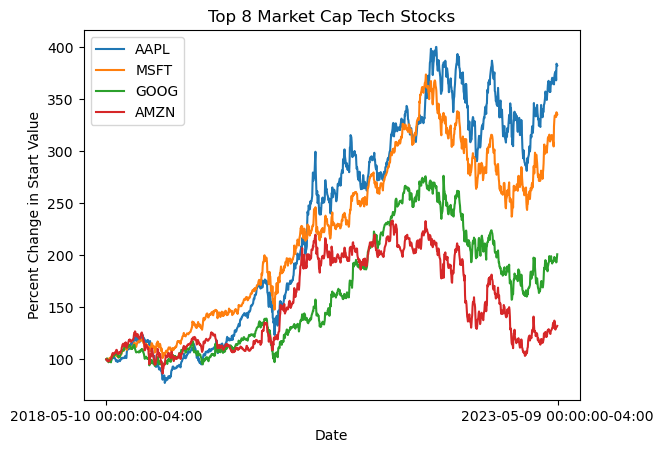

In [4]:
for ticker in used_tech:
    stval = datas[ticker]['High'][0]
    datas[ticker]['High'].apply(lambda x: 100*x/stval).plot()
plt.legend(top_4_tech)
plt.ylabel("Percent Change in Start Value")
plt.title("Top 8 Market Cap Tech Stocks")
plt.xticks([0, len(datas[ticker]-1)], [datas[ticker].index[0], datas[ticker].index[-1]], rotation=0)